**Grid Deep Dive: Einzelanalyse auffälliger Grids**

- Zeitmuster und Unfalltypen einzelner Grids im Vergleich zum Kölner Durchschnitt
- Vergleichstabelle: Excess Grid vs strukturell ähnliches Safe Grid
- Karte mit Unfall und Bar Standorten

### Setup
- Geometrien nochmal aus dem Original laden (Parquets haben kein WKB)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from folium import FeatureGroup
from shapely import wkb
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install osmnx -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.4/104.4 kB 2.9 MB/s eta 0:00:00


In [3]:
target = "Acc_EN"  # Zielvariable: Unfälle in Abend/Nacht

utyp_map = {
    1: 'Fahrunfall', 2: 'Abbiegeunfall', 3: 'Einbiegen/Kreuzen',
    4: 'Überschreiten', 5: 'Ruhender Verkehr', 6: 'Längsverkehr', 7: 'Sonstiger'
}

In [5]:
df = pd.read_parquet("grid_with_predictions.parquet")
uf_joined = pd.read_parquet("unfaelle_with_grid.parquet")

print(f"Grids: {len(df)}, Unfälle: {len(uf_joined)}")
df[["GridID", "ZoneType_4", target, "predicted", "residual"]].head(10)

Grids: 1324, Unfälle: 12488


,GridID,ZoneType_4,Acc_EN,predicted,residual
0,34,Barlos,0.0,0.299043,-0.299043
1,35,Barlos,1.0,0.445903,0.554097
2,36,Barlos,0.0,0.829103,-0.829103
3,37,Barlos,0.0,0.036584,-0.036584
4,47,Barlos,0.0,0.329218,-0.329218
5,48,Barlos,3.0,3.556212,-0.556212
6,49,Barlos,0.0,1.021201,-1.021201
7,50,Bararm,0.0,1.577111,-1.577111
8,51,Barlos,0.0,1.024176,-1.024176
9,52,Barlos,0.0,0.018104,-0.018104


In [7]:
gf_raw = pd.read_parquet("grid_features.parquet")
gf_geo = gf_raw[["GridID", "geometry"]].copy()
gf_geo["geometry"] = gf_geo["geometry"].apply(lambda b: wkb.loads(b) if isinstance(b, (bytes, bytearray)) else b)  # Parquet speichert Geometrie als Bytes
grid_gdf = gpd.GeoDataFrame(gf_geo, geometry="geometry", crs="EPSG:25832").to_crs("EPSG:4326")  # auf WGS84 für Folium
del gf_raw

In [8]:
def get_grid_accidents(grid_id):
    # Alle Einzelunfälle eines Grids
    return uf_joined[uf_joined.GridID == grid_id].copy()

def get_grid_info(grid_id):
    # Aggregierte Grid-Daten (Bars, Predicted, Residual, etc)
    row = df[df.GridID == grid_id]
    if len(row) == 0:
        print(f"Grid {grid_id} nicht gefunden")
        return None
    return row.iloc[0]

### Zeitanalyse
- Stundenverteilung und Wochentagsverteilung pro Grid
- WE/WT Ratio: Unfälle pro Tag am Wochenende vs Werktag

In [9]:
def time_analysis(grid_id):
    acc = get_grid_accidents(grid_id)
    info = get_grid_info(grid_id)

    print(f"Grid {grid_id} | {len(acc)} Unfälle | {info.bar_count:.0f} Bars | Residual {info.residual:+.1f}")

    # Stundenverteilung und Nachtanteil
    hours = acc.USTUNDE.value_counts().reindex(range(24), fill_value=0)
    night_share = acc.is_night.mean()
    print(f"Peak: {hours.idxmax()} Uhr ({hours.max()} Unfälle), Nachtanteil: {night_share:.0%}")

    # Wochenende vs Werktag, normalisiert auf Unfälle pro Tag
    we = acc[acc.UWOCHENTAG.isin([6, 7])]
    wd = acc[~acc.UWOCHENTAG.isin([6, 7])]
    we_rate = len(we) / 2 if len(we) > 0 else 0  # 2 WE-Tage
    wd_rate = len(wd) / 5 if len(wd) > 0 else 0  # 5 Werktage
    if wd_rate > 0:
        print(f"WE/WT Ratio: {we_rate/wd_rate:.2f}x ({we_rate:.1f}/Tag vs {wd_rate:.1f}/Tag)")

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # Stundenplot: dunkel=Nacht, rot=Abend, blau=Tag
    colors = ['#2c3e50' if h < 6 or h >= 22 else '#e74c3c' if 18 <= h < 22 else '#3498db' for h in range(24)]
    axes[0].bar(range(24), hours.values, color=colors, edgecolor='white', linewidth=0.5)
    axes[0].set_xlabel('Stunde')
    axes[0].set_ylabel('Unfälle')
    axes[0].set_title(f'Grid {grid_id} - Stundenverteilung')
    axes[0].set_xticks(range(0, 24, 2))

    # Wochentagplot: blau=Werktag, rot=Wochenende
    if 'UWOCHENTAG_Name' in acc.columns:
        days_order = ['Montag', 'Dienstag', 'Mittwoch', 'Donnerstag', 'Freitag', 'Samstag', 'Sonntag']
        day_counts = acc.UWOCHENTAG_Name.value_counts().reindex(days_order, fill_value=0)
        axes[1].bar(range(7), day_counts.values, color=['#3498db']*5 + ['#e74c3c']*2, edgecolor='white', linewidth=0.5)
        axes[1].set_xticks(range(7))
        axes[1].set_xticklabels(['Mo','Di','Mi','Do','Fr','Sa','So'])
    axes[1].set_title(f'Grid {grid_id} - Wochentag')
    axes[1].set_ylabel('Unfälle')

    plt.tight_layout()
    plt.show()

### Unfalltypen und Beteiligte
- Unfalltypen und Beteiligte im Vergleich zum Kölner Durchschnitt

In [10]:
def type_analysis(grid_id):
    acc = get_grid_accidents(grid_id)
    info = get_grid_info(grid_id)
    all_acc = uf_joined[uf_joined.GridID.isin(df.GridID)]  # ganz Köln als Vergleich

    print(f"Grid {grid_id} | {len(acc)} Unfälle | {info.bar_count:.0f} Bars | Residual {info.residual:+.1f}")

    # Unfalltypen: Anteil im Grid vs Köln-Durchschnitt
    print("\nUnfalltypen:")
    for utyp, name in utyp_map.items():
        n = len(acc[acc.UTYP1 == utyp])
        if n > 0:
            grid_share = n / len(acc)
            all_share = len(all_acc[all_acc.UTYP1 == utyp]) / len(all_acc)
            diff = grid_share - all_share
            marker = "<<" if diff < -0.05 else (">>" if diff > 0.05 else "  ")  # 5pp Schwelle
            print(f"  {marker} {name:25s}: {n:3d} ({grid_share:5.1%}) vs Köln {all_share:5.1%}")

    # Beteiligte Verkehrsteilnehmer: Grid vs Köln
    beteiligte = [('IstPKW','PKW'), ('IstRad','Rad'), ('IstFuss','Fußgänger'),
                  ('IstKrad','Motorrad'), ('IstGkfz','Güterkfz')]

    print(f"\n{'Typ':15s} {'Grid':>8s} {'Grid%':>8s} {'Köln%':>8s}")
    for col, label in beteiligte:
        if col not in acc.columns:
            continue
        n = acc[col].sum()
        grid_pct = n / len(acc) if len(acc) > 0 else 0
        all_pct = all_acc[col].sum() / len(all_acc) if len(all_acc) > 0 else 0
        print(f"{label:15s} {n:8.0f} {grid_pct:7.1%} {all_pct:7.1%}")

### Matched Grid finden
- Sucht ein Vergleichsgrid mit ähnlicher Bar-Dichte, Lage und Straßenlänge aber weniger Unfällen als erwartet

In [11]:
def find_matched_grid(grid_id_ref, bar_tol=0.60, dist_tol=1500, road_tol=0.60, require_safe=True):
    # Findet ein Vergleichsgrid mit ähnlicher Struktur aber weniger Unfällen (simpel)
    r = df[df["GridID"] == grid_id_ref].iloc[0]
    cand = df[df["GridID"] != grid_id_ref].copy()

    # filtern: ähnliche Bars, Lage und Straßenlänge
    cand = cand[
        (cand["bar_count"].between(r["bar_count"] * (1 - bar_tol), r["bar_count"] * (1 + bar_tol))) &
        (cand["dist_center"].between(r["dist_center"] - dist_tol, r["dist_center"] + dist_tol)) &
        (cand["road_km"].between(r["road_km"] * (1 - road_tol), r["road_km"] * (1 + road_tol)))
    ].copy()

    if cand.empty:
        print("Kein Match gefunden")
        return None

    # Score: je kleiner desto ähnlicher
    cand["match_score"] = (
        ((cand["bar_count"] - r["bar_count"]).abs() / (r["bar_count"] + 1)) +  # +1 falls bar count=0
        ((cand["dist_center"] - r["dist_center"]).abs() / (dist_tol + 1)) +
        ((cand["road_km"] - r["road_km"]).abs() / (r["road_km"] + 1))
    )

    # wenn möglich nur Grids mit weniger Unfällen als erwartet
    if require_safe:
        cand_safe = cand[cand["residual"] < 0]
        if not cand_safe.empty:
            cand = cand_safe

    best = cand.sort_values(["match_score", "residual"]).iloc[0]
    return int(best["GridID"])

### Karte und Vergleichstabelle
- Vergleichstabelle zeigt Infrastruktur und Unfallmerkmale nebeneinander

In [12]:
def make_two_grids_map(grid_id_a, grid_id_b, show_bars=False):
    # Interaktive Karte mit beiden Grids, Unfällen und optional Bars
    poly_a = grid_gdf[grid_gdf.GridID == grid_id_a].geometry.iloc[0]
    poly_b = grid_gdf[grid_gdf.GridID == grid_id_b].geometry.iloc[0]

    # Kartenausschnitt etwas größer als die beiden Grids
    minx = min(poly_a.bounds[0], poly_b.bounds[0]) - 0.0015
    miny = min(poly_a.bounds[1], poly_b.bounds[1]) - 0.0015
    maxx = max(poly_a.bounds[2], poly_b.bounds[2]) + 0.0015
    maxy = max(poly_a.bounds[3], poly_b.bounds[3]) + 0.0015

    center = [(miny + maxy) / 2, (minx + maxx) / 2]
    m = folium.Map(location=center, tiles="CartoDB positron", zoom_start=15)

    layer_grids = FeatureGroup(name="Grids", show=True)
    layer_unfaelle = FeatureGroup(name="Unfälle", show=True)
    layer_bars = FeatureGroup(name="Bars", show=False)

    for gid, poly in [(grid_id_a, poly_a), (grid_id_b, poly_b)]:
        # Grid-Umriss
        folium.GeoJson(
            poly.__geo_interface__,
            style_function=lambda x: {"fillColor": "blue", "color": "blue", "weight": 3, "fillOpacity": 0.03},
        ).add_to(layer_grids)

        # Unfälle als Punkte, eingefärbt nach Tageszeit
        acc = get_grid_accidents(gid)
        for _, a in acc.iterrows():
            if a.is_night == 1:
                color = "darkred"
            elif "ZeitKategorie" in acc.columns and a.ZeitKategorie in ["Abend", "Spätabend"]:
                color = "orange"
            else:
                color = "cadetblue"

            utyp = utyp_map.get(a.UTYP1, "?")
            parts = [f"<b>{utyp}</b>", f"Grid {gid}"]
            if "UWOCHENTAG_Name" in acc.columns:
                parts.append(f"{a.UWOCHENTAG_Name} {a.USTUNDE}:00")

            folium.CircleMarker(
                location=[a.YGCSWGS84, a.XGCSWGS84],
                radius=5, color=color, fill=True, fillOpacity=0.85,
                popup=folium.Popup("<br>".join(parts), max_width=220),
            ).add_to(layer_unfaelle)

    # Bars von OSM laden
    if show_bars:
        try:
            import osmnx as ox
            for poly in [poly_a, poly_b]:
                pois = ox.features_from_polygon(poly, tags={"amenity": ["bar", "pub", "nightclub"]})
                for _, row in pois.iterrows():
                    geom = row.geometry
                    if geom is None:
                        continue
                    pt = geom if geom.geom_type == "Point" else geom.centroid  # Ways haben keinen Punkt
                    folium.CircleMarker(
                        location=[pt.y, pt.x], radius=3,
                        color="purple", fill=True, fillOpacity=0.35, opacity=0.35,
                    ).add_to(layer_bars)
        except Exception as e:
            print(f"OSM Bars nicht geladen: {e}")

    layer_grids.add_to(m)
    layer_unfaelle.add_to(m)
    layer_bars.add_to(m)

    # Legende
    legend_html = """
    <div style="position:fixed; bottom:30px; left:30px; z-index:1000;
         background:white; padding:10px; border-radius:6px; border:1px solid grey;">
    <b>Tageszeit (Unfälle)</b><br>
    <span style="color:darkred;">&#9679;</span> Nacht (23-5)<br>
    <span style="color:orange;">&#9679;</span> Abend (18+)<br>
    <span style="color:cadetblue;">&#9679;</span> Tag<br><br>
    <b>OSM</b><br>
    <span style="color:purple;">&#9679;</span> Bar/Pub/Nightclub
    </div>
    """
    m.get_root().html.add_child(folium.Element(legend_html))
    return m

In [13]:
def comparison_table(grid_a, grid_b):
    # Vergleichstabelle zweier Grids als Plot
    row_a = df.set_index("GridID").loc[grid_a]
    row_b = df.set_index("GridID").loc[grid_b]
    acc_a = get_grid_accidents(grid_a)
    acc_b = get_grid_accidents(grid_b)

    # Hilfsfunktionen für Prozentwerte aus Einzelunfällen
    def pct(acc, col):
        return float(acc[col].mean() * 100) if len(acc) > 0 and col in acc.columns else np.nan

    def utyp_pct(acc, code):
        return float((acc["UTYP1"] == code).mean() * 100) if len(acc) > 0 else np.nan

    labels = [
        "Unfälle (Abend/Nacht)", "Erwartet (Modell)", "Excess (Ist-Erwartet)",
        "Straßenlänge (km)", "Hauptstraßen-km (Proxy)",
        "Unfälle pro km Straße", "Unfälle pro km Hauptstraße",
        "Nachtanteil (%)", "Zebrastreifen pro km", "Einbahn-Anteil",
        "Abbiegeunfall (%)", "Radfahrer beteiligt (%)"
    ]

    # Hauptstraßen km aus Anteil berechnen
    major_a = row_a["road_km"] * row_a["major_road_km_share"]
    major_b = row_b["road_km"] * row_b["major_road_km_share"]

    vals_a = [
        row_a["Acc_EN"], row_a["predicted"], row_a["residual"],
        row_a["road_km"], major_a,
        row_a["Acc_EN"] / row_a["road_km"] if row_a["road_km"] > 0 else 0,
        row_a["Acc_EN"] / major_a if major_a > 0 else 0,
        pct(acc_a, "is_night"), row_a["crossings_per_roadkm"], row_a["oneway_km_share"],
        utyp_pct(acc_a, 2), pct(acc_a, "IstRad")
    ]
    vals_b = [
        row_b["Acc_EN"], row_b["predicted"], row_b["residual"],
        row_b["road_km"], major_b,
        row_b["Acc_EN"] / row_b["road_km"] if row_b["road_km"] > 0 else 0,
        row_b["Acc_EN"] / major_b if major_b > 0 else 0,
        pct(acc_b, "is_night"), row_b["crossings_per_roadkm"], row_b["oneway_km_share"],
        utyp_pct(acc_b, 2), pct(acc_b, "IstRad")
    ]

    tab = pd.DataFrame({
        "": labels,
        f"Grid {grid_a} (Problem)": [round(v, 2) if pd.notna(v) else "" for v in vals_a],
        f"Grid {grid_b} (Safe)": [round(v, 2) if pd.notna(v) else "" for v in vals_b],
    })

    # Zeilen die im Plot rot hinterlegt werden
    highlight = {"Excess (Ist-Erwartet)", "Nachtanteil (%)", "Zebrastreifen pro km",
                 "Einbahn-Anteil", "Abbiegeunfall (%)", "Radfahrer beteiligt (%)",
                 "Unfälle pro km Straße", "Unfälle pro km Hauptstraße"}

    fig, ax = plt.subplots(figsize=(10, 5.5))
    ax.axis("off")

    tbl = ax.table(cellText=tab.values, colLabels=tab.columns, loc="center", cellLoc="center")
    tbl.scale(1, 1.5)

    for (r, c), cell in tbl.get_celld().items():
        if r == 0:
            cell.set_text_props(weight="bold")
            continue
        row_name = tab.iloc[r - 1, 0]
        if row_name in highlight:
            cell.set_facecolor("#f4cccc")

    plt.title(f"Grid {grid_a} vs {grid_b}", pad=12)
    plt.tight_layout()
    plt.show()

### Beispiel: Grid 683 vs 684

Grid 683 | Hotspot | 66 Bars | Actual=75 Pred=48.5 Res=+26.5

Grid 683 | 112 Unfälle | 66 Bars | Residual +26.5
Peak: 17 Uhr (10 Unfälle), Nachtanteil: 29%
WE/WT Ratio: 0.96x (15.5/Tag vs 16.2/Tag)


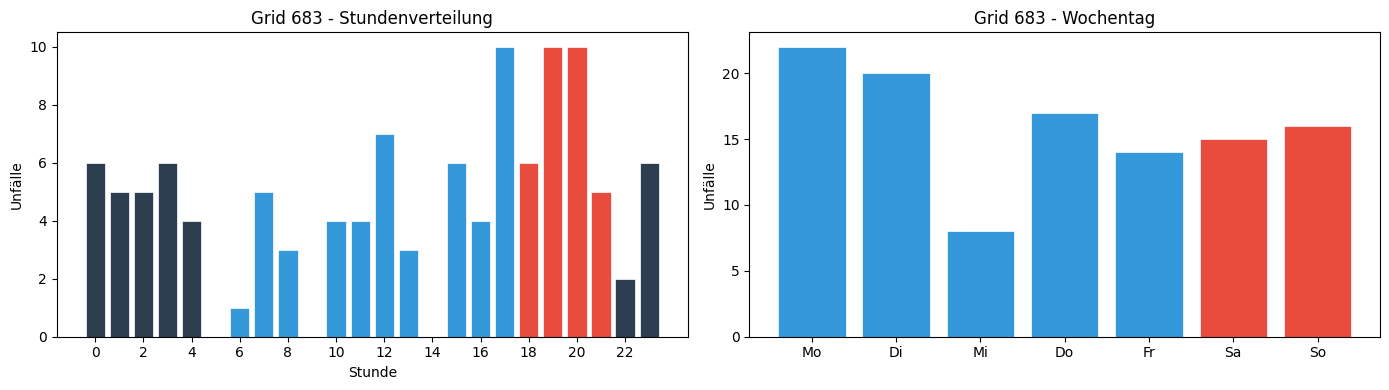


Grid 683 | 112 Unfälle | 66 Bars | Residual +26.5

Unfalltypen:
     Fahrunfall               :  22 (19.6%) vs Köln 17.9%
  << Abbiegeunfall            :   8 ( 7.1%) vs Köln 15.3%
  << Einbiegen/Kreuzen        :  11 ( 9.8%) vs Köln 16.3%
     Überschreiten            :  12 (10.7%) vs Köln  6.7%
  >> Ruhender Verkehr         :  15 (13.4%) vs Köln  6.8%
  << Längsverkehr             :  19 (17.0%) vs Köln 23.8%
  >> Sonstiger                :  25 (22.3%) vs Köln 13.2%

Typ                 Grid    Grid%    Köln%
------------------------------------------
PKW                   51   45.5%   70.4%
Rad                   63   56.2%   41.7%
Fußgänger             25   22.3%   13.2%
Motorrad              15   13.4%   11.8%
Güterkfz               1    0.9%    4.0%


In [14]:
info = get_grid_info(683)
print(f"Grid 683 | {info.ZoneType_4} | {info.bar_count:.0f} Bars | "
      f"Actual={info[target]:.0f} Pred={info.predicted:.1f} Res={info.residual:+.1f}")
print()
time_analysis(683)
print()
type_analysis(683)

In [15]:
safe_id = find_matched_grid(683)
print(f"Matched safe grid für 683: {safe_id}")

Matched safe grid für 683: 684


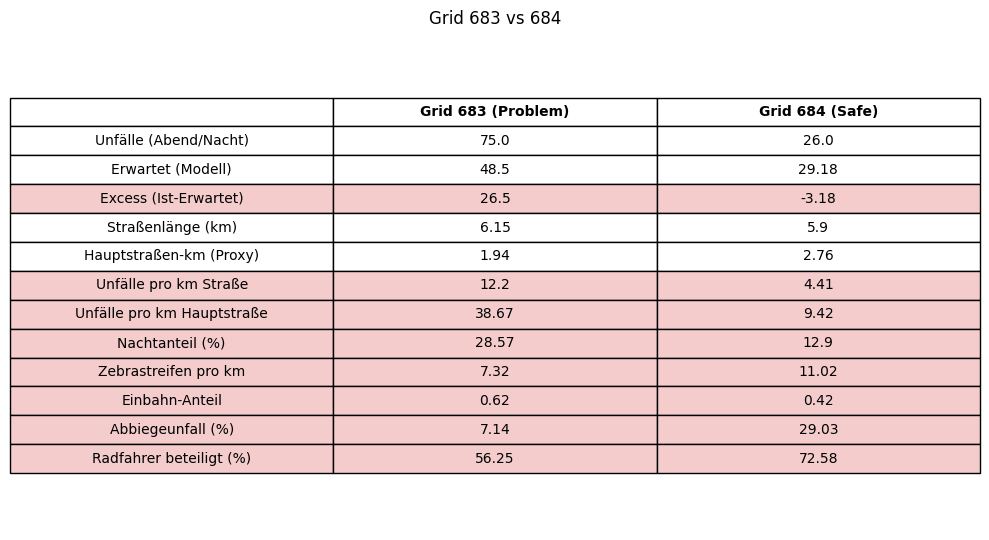

In [16]:
comparison_table(683, 684)

In [17]:
display(make_two_grids_map(683, 684, show_bars=True))